In [1]:
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from IPython.display import Image as show_gif

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage
from skimage.transform import rotate
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

#from volumentations import *
import albumentations as A
from albumentations.pytorch import ToTensorV2 
from albumentations import (HorizontalFlip,
                            VerticalFlip,
                            Normalize,
                            Compose)


import warnings
warnings.simplefilter("ignore")

In [2]:
class Image3dToGIF3d:
    
    def __init__(self, 
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                 is_check_shapes=False,
                ):
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
       
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded
    
    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z
    
    def _normalize(self, arr: np.ndarray):
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    
    def _scale_by(self, arr: np.ndarray, factor: int):
        
        mean = np.mean(arr)
        return (arr - mean) * factor + mean
    
    def get_transformed_data(self, data: np.ndarray):
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)
            
        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)
        
        return resized_data
    
    def plot_cube(self,
                  cube,
                  title: str = '', 
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
       
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")
            
        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()
            else:
                plt.show()
                
def merging_two_gif(path1: str, path2: str, name_to_save: str):

    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)

    #If they don't have the same number of frame take the shorter
    number_of_frames = min(gif1.get_length(), gif2.get_length()) 

    #Create writer object
    new_gif = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        img1 = gif1.get_next_data()
        img2 = gif2.get_next_data()
        new_image = np.hstack((img1, img2))
        new_gif.append_data(new_image)

    gif1.close()
    gif2.close()    
    new_gif.close()

In [3]:
class GlobalConfig:
    root_dir = r'C:\DATASET_BRAIN_TURMOR\brats20-dataset-training-validation'
    train_root_dir = r'C:\DATASET_BRAIN_TURMOR\brats20-dataset-training-validation\MICCAI_BraTS2020_TrainingData'
    test_root_dir = r'C:\DATASET_BRAIN_TURMOR\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData'
    path_to_csv = r'C:\DATASET_BRAIN_TURMOR\last\train_data.csv'
    ae_pretrained_model_path = r"C:\Users\Storbiiic\Downloads\archive (1)\brats2020logs\ae\autoencoder_best_model.pth"
    pretrained_model_path = r'C:\DATASET_BRAIN_TURMOR\last\last_epoch_model_modified11.pth'
    train_logs_path = r'C:\DATASET_BRAIN_TURMOR\last\train_log_modified11.csv'
    seed = 55
    is_check_shapes=False
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)



In [4]:
survival_info_df = pd.read_csv(r'C:\DATASET_BRAIN_TURMOR\brats20-dataset-training-validation\MICCAI_BraTS2020_TrainingData\survival_info.csv')
name_mapping_df = pd.read_csv(r'C:\DATASET_BRAIN_TURMOR\brats20-dataset-training-validation\MICCAI_BraTS2020_TrainingData\name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

paths = []
for index, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)
    
df['path'] = paths

train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, ) #eliminam pacientul 355 deoarece formatul nu este bun

# impartim data in antrenare (train), validare (val) si evaluare (test)
skf = StratifiedKFold(n_splits=2, random_state=config.seed, shuffle=True) #impartim setul de date in 7 parti folosind un seed pentru a obtine mereu aceeasi ordine
for i, (train_index, val_index) in enumerate(skf.split(train_data, train_data["Age"]//10*10)):
        train_data.loc[val_index, "fold"] = i

train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("train_data.csv", index=False)

train_df -> (117, 11) val_df -> (118, 11) test_df -> (133, 10)


In [5]:
def load_img1(file_path):
    data = nib.load(file_path)
    return data
tumor_core_total=0
peritumoral_edema_total=0
enhancing_tumor_total=0
num_zeros_total=0
for idx in train_data['Brats20ID']:
    root_path = train_data.loc[train_data['Brats20ID'] == idx]['path'].values[0] # preluam calea din fisierul csv
    img_path = os.path.join(root_path +'/' + idx+  '_seg.nii')
    img = load_img1(img_path)
    a = np.array(img.dataobj)
    b=a.flatten()

    tumor_core=np.count_nonzero(b == 1)
    tumor_core_total=tumor_core_total+tumor_core
    
    peritumoral_edema=np.count_nonzero(b==2)
    peritumoral_edema_total=peritumoral_edema_total+peritumoral_edema
    
    enhancing_tumor=np.count_nonzero(b==4)
    enhancing_tumor_total=enhancing_tumor_total+enhancing_tumor
    
    num_zeros = (b == 0).sum()
    num_zeros_total=num_zeros_total+num_zeros
print(tumor_core_total)
print(peritumoral_edema_total)
print(enhancing_tumor_total)
print(num_zeros_total)
print(tumor_core_total+peritumoral_edema_total+enhancing_tumor_total+num_zeros_total)

2877451
13244475
5250041
2076708033
2098080000


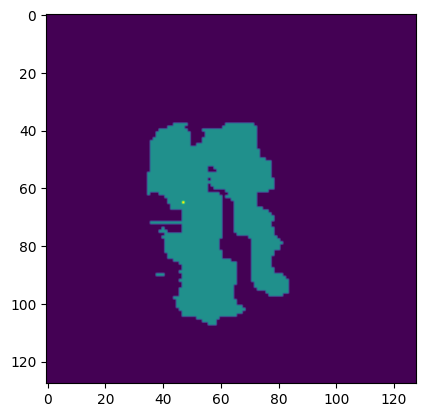

(128, 128, 128)


<Figure size 640x480 with 0 Axes>

In [6]:
def get_center_crop_coords(height, width, depth, crop_height, crop_width, crop_depth):
                x1 = (height - crop_height) // 2
                x2 = x1 + crop_height
                y1 = (width - crop_width) // 2
                y2 = y1 + crop_width
                z1 = (depth - crop_depth) // 2
                z2 = z1 + crop_depth
                return x1, y1, z1, x2, y2, z2

def center_crop(data:np.ndarray, crop_height, crop_width, crop_depth):
    height, width, depth = data.shape[:3]
    if height < crop_height or width < crop_width or depth < crop_depth:
        raise ValueError
    x1, y1, z1, x2, y2, z2 = get_center_crop_coords(height, width, depth, crop_height, crop_width, crop_depth)
    data = data[x1:x2, y1:y2, z1:z2]
    return data

def load_img1(file_path):
    data = nib.load(file_path)
    return data
tumor_core_total=0
peritumoral_edema_total=0
enhancing_tumor_total=0
num_zeros_total=0
for idx in train_data['Brats20ID']:
    root_path = train_data.loc[train_data['Brats20ID'] == idx]['path'].values[0] # preluam calea din fisierul csv
    img_path = os.path.join(root_path +'/' + idx+  '_seg.nii')
    img = load_img1(img_path)
    a = np.array(img.dataobj)
    get_center_crop_coords(240,240,155, 128,128,128)
    a=center_crop(a, 128,128,128)
    plt.imshow(a[10])
    plt.show()
    plt.savefig('foo.png')
    print(a.shape)
    break
    

In [7]:
def load_img1(file_path):
    data = nib.load(file_path)
    return data
tumor_core_total=0
peritumoral_edema_total=0
enhancing_tumor_total=0
num_zeros_total=0

for idx in val_df['Brats20ID']:
    root_path = val_df.loc[val_df['Brats20ID'] == idx]['path'].values[0] # preluam calea din fisierul csv
    img_path = os.path.join(root_path +'/' + idx+  '_seg.nii')
    img = load_img1(img_path)
    a = np.array(img.dataobj)
    b=a.flatten()
#     unique, counts = np.unique(b, return_counts=True)
#     dict(zip(unique, counts))
    tumor_core=np.count_nonzero(b == 1)
    tumor_core_total=tumor_core_total+tumor_core
    
    peritumoral_edema=np.count_nonzero(b==2)
    peritumoral_edema_total=peritumoral_edema_total+peritumoral_edema
    
    enhancing_tumor=np.count_nonzero(b==4)
    enhancing_tumor_total=enhancing_tumor_total+enhancing_tumor
    
    num_zeros = (b == 0).sum()
    num_zeros_total=num_zeros_total+num_zeros
print(tumor_core_total)
print(peritumoral_edema_total)
print(enhancing_tumor_total)
print(num_zeros_total)

1449588
6556121
2518182
1042980109


# 3DAutoEncoder

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(4, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.enc_linear = nn.Linear(381216, 512)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 4, 3)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

        self.dec_linear = nn.Linear(512, 381216)
        
    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, indices1 = self.pool1(x)
        x = self.conv2(x)
        up2out_shape = x.shape
        x, indices2 = self.pool2(x)
        x = self.conv3(x)
        up1out_shape = x.shape
        x, indices3 = self.pool3(x)
        #print(x.shape)
        x = x.view((x.size(0), -1))
        #print(x.shape)
        x = self.enc_linear(x)

        # required for unpool
        pool_par = {
            "P1": [indices1, up3out_shape], 
            "P2": [indices2, up2out_shape], 
            "P3": [indices3, up1out_shape]
                   }
        
        if return_partials:
            return x, pool_par
        else:
            return x

    def decode(self, x, pool_par):
        x = self.dec_linear(x)
        x = x.view((x.size(0), 96, 11, 19, 19))
        
        x = self.unpool1(x, output_size=pool_par["P3"][1], indices=pool_par["P3"][0])
        #print(x.shape)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=pool_par["P2"][1], indices=pool_par["P2"][0])
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=pool_par["P1"][1], indices=pool_par["P1"][0])
        x = self.deconv3(x)
        return x
    
    def forward(self, x):
        self.feature, pool_par = self.encode(x)
        out = self.decode(self.feature, pool_par)
        return out

### Dataset and Dataloader

In [9]:
def get_augmentations(phase):
    list_transforms = []
    
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 0,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [10]:
class AutoEncoderDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = "test"):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)

            img = self.normalize(img)
            images.append(img.astype(np.float32))
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
    
        
        return {
            "Id": id_,
            "data": img,
            "label": img,
            }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray,  mean=0.0, std=1.0):
        """Normilize image value between 0 and 1."""
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
        

In [11]:
dataloader = get_dataloader(dataset=AutoEncoderDataset, path_to_csv='train_data.csv', phase='valid', fold=0,num_workers=0)
len(dataloader)

118

In [12]:
data = next(iter(dataloader))
data['Id'], data['data'].shape, data['label'].shape

(['BraTS20_Training_353'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 4, 155, 240, 240]))

### training process

In [13]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 dataset: torch.utils.data.Dataset,
                ):

        """Initialization."""
        self.device = 'cpu' #if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {

            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['data'], data_batch['label']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches

        
        self.losses[phase].append(epoch_loss)
        print(f"Loss | {self.losses[phase][-1]}")


        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "autoencoder_best_model.pth")
            print()
        self._save_train_history()
            
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"autoencoder_last_epoch_model.pth")


In [14]:
torch.cuda.empty_cache()
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:768"

In [15]:
model = AutoEncoder().to('cuda')

trainer = Trainer(net=model,
                  dataset= AutoEncoderDataset,
                  criterion=MSELoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=1,
                  path_to_csv = config.path_to_csv,)


if config.ae_pretrained_model_path is not None:
    trainer.load_predtrain_model(config.ae_pretrained_model_path)

device: cpu
Predtrain model loaded


In [16]:
%%time
trainer.run()

train epoch: 0 | time: 23:29:53


RuntimeError: DataLoader worker (pid(s) 5692, 4500, 5756, 9700) exited unexpectedly

Checking quality of AE 

In [ ]:
dataloader = get_dataloader(AutoEncoderDataset, 'train_data.csv', phase='val', fold=0)

In [ ]:
model.eval();
with torch.no_grad():
    for data in dataloader:
        id_, imgs, targets = data['Id'], data['data'], data['label']
        imgs, targets = imgs.to('cuda'), targets.to('cuda')
        output = model(imgs)
        output = output.cpu()
        break

ground truth

In [ ]:
imgs = imgs.squeeze().cpu().numpy()
imgs = np.moveaxis(imgs, (0, 1, 2, 3), (0, 3, 2, 1))
print(imgs.shape)

gt_flair, gt_t1, gt_t1ce, gt_t2 = imgs
print(gt_flair.shape, gt_t1.shape, gt_t1ce.shape, gt_t2.shape)

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(np.rot90(montage(gt_flair)), cmap='bone')

In [ ]:
%%time
title = "AE_Ground_Truth_" + id_[0]
filename1 = title + "_3d.gif"


data_to_3dgif = Image3dToGIF3d(img_dim = (55, 55, 55), binary=False, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(gt_flair)
#transformed_data = np.rot90(transformed_data)
data_to_3dgif.plot_cube(
    transformed_data[:38, :47, :35],
    title=title,
    make_gif=True,
    path_to_save=filename1
)
#show_gif(filename1, format='png')

prediction

In [ ]:
output = output.squeeze().numpy()
output = np.moveaxis(output, (0, 1, 2, 3), (0, 3, 2, 1))
print(output.shape)

pr_flair, pr_t1, pr_t1ce, pr_t2 = output
print(pr_flair.shape, pr_t1.shape, pr_t1ce.shape, pr_t2.shape)

In [ ]:
plt.figure(figsize=(15, 10))
pr_flair1 = pr_flair.copy()
pr_flair1[pr_flair1 < 1e-7] = 0  # remove artifacts.
plt.imshow(np.rot90(montage(pr_flair1)), cmap='bone')

In [ ]:
%%time
title = "AE_Prediction_" + id_[0]
filename2 = title + "_3d.gif"


data_to_3dgif = Image3dToGIF3d(img_dim = (55, 55, 55), binary=False, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(pr_flair1)
#transformed_data = np.rot90(transformed_data)
data_to_3dgif.plot_cube(
    transformed_data[:38, :47, :35],
    title=title,
    make_gif=True,
    path_to_save=filename2
)
#show_gif(filename1, format='png')"""

In [ ]:
merging_two_gif(filename1,
                filename2, 
                'AE_result.gif')
show_gif('AE_result.gif', format='png')

Now let's generates all latent features

In [ ]:
class LatentFeaturesGenerator:
    def __init__(self, 
                 autoencoder, 
                 device: str = 'cuda'):
        
        self.autoencoder = autoencoder.to(device)
        self.device = device

    def __call__(self, img):
        with torch.no_grad():
            img = torch.FloatTensor(img).unsqueeze(0).to(self.device)
            latent_features = self.autoencoder.encode(
                img, return_partials=False).squeeze(0).cpu().numpy()

        return latent_features

In [ ]:
class Features_Generator:
    
    def __init__(self, df, autoencoder):
        self.df = df
        self.df_voxel_stats = pd.DataFrame()
        self.latent_feature_generator = LatentFeaturesGenerator(autoencoder)
        
    def _read_file(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj).astype(np.float32)
        return data
    
    def _normalize(self, data: np.ndarray):
        """Normilize image value between 0 and 1."""
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def _create_features(self, Brats20ID):
        features = {}
        images = []
        # vOXEL STATS
        for data_type in ['_t1.nii', '_t2.nii', '_flair.nii', '_t1ce.nii']:
            
            
            # data path
            root_path = self.df.loc[self.df['Brats20ID'] == Brats20ID]['path'].values[0]
            file_path = os.path.join(root_path, Brats20ID + data_type)
            
            # flatten 3d array
            img_data = self._read_file(file_path)
            data = img_data.reshape(-1)
            
            # create features
            data_mean = data.mean()
            data_std = data.std()
            intensive_data = data[data > data_mean]
            more_intensive_data = data[data > data_mean + data_std]
            non_intensive_data = data[data < data_mean]
            
            data_skew = stats.skew(data)
            data_kurtosis = stats.kurtosis(data)
            intensive_skew = stats.skew(intensive_data)
            non_intensive_skew = stats.skew(non_intensive_data)
            
            data_diff = np.diff(data)
            
            # write new features in df
            features['Brats20ID'] = Brats20ID
            features[f'{data_type}_skew'] = data_skew,
            features[f'{data_type}_kurtosis'] = data_kurtosis,
            features[f'{data_type}_diff_skew'] = stats.skew(data_diff),
            features[f'{data_type}_intensive_dist'] = intensive_data.shape[0],
            features[f'{data_type}_intensive_skew'] = intensive_skew,
            features[f'{data_type}_non_intensive_dist'] = non_intensive_data.shape[0],
            features[f'{data_type}_non_intensive_skew'] = non_intensive_skew,
            #features[f'{data_type}_intensive_non_intensive_mean_ratio'] = intensive_data.mean() / non_intensive_data.mean(),
            #features[f'{data_type}_intensive_non_intensive_std_ratio'] = intensive_data.std() / non_intensive_data.std(),
            features[f'{data_type}_data_intensive_skew_difference'] = data_skew - intensive_skew,
            features[f'{data_type}_data_non_intensive_skew_difference'] = data_skew - non_intensive_skew,
            features[f'{data_type}_more_intensive_dist'] = more_intensive_data.shape[0],
            
            parts = 15
            for p, part in enumerate(np.array_split(data, parts)):
                features[f'{data_type}_part{p}_mean'] = part.mean()
                
            # Latent Features    
            img = self._normalize(img_data)
            images.append(img.astype(np.float32))
            
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        latent_features = self.latent_feature_generator(img)
        
        for i, lf in enumerate(latent_features):
                features[f'latent_f{i}'] = lf
          
        return pd.DataFrame(features)
    
    
    def run(self):
        
        for _, row in tqdm(self.df.iterrows()):
            ID = row['Brats20ID']
            
            df_features = self._create_features(ID)
            
            self.df_voxel_stats  = pd.concat([self.df_voxel_stats, df_features], axis=0) 
            
        self.df_voxel_stats.reset_index(inplace=True, drop=True) 
        self.df_voxel_stats = self.df_voxel_stats.merge(self.df[['Brats20ID', 'Age', 'Survival_days']], on='Brats20ID', how='left')
            

In [ ]:
%%time
model.eval();
fg =  Features_Generator(df, model)
fg.run()
fg.df_voxel_stats.to_csv("df_with_voxel_stats_and_latent_features.csv", index=False)
fg.df_voxel_stats

Now that we have tabular data, we can use it to predict age and survival days.
we will use SVR for this purpose.

In [ ]:
df = pd.read_csv("df_with_voxel_stats_and_latent_features.csv")#

df['is_train'] = 0
df['is_train'].loc[df['Survival_days'].notnull()] = 1

df['SD'] = df['Survival_days'].str.extract(r'(\d+[.\d]*)')
df['SD'] = df['SD'].astype("float64")
df['Age'] = df['Age'].astype("float64")
df.sample(5)

In [ ]:
test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()
print("train ->", df.shape, "test ->", test_df.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(df['Age'].apply(lambda x: np.round(x, 0)), ax=ax, palette='Dark2')

ax.set_xticks(ax.get_xticks()[::2]);
ax.set_ylabel('number of unique (rounded) ages', fontsize=20)
ax.set_xlabel('unique (rounded) ages', fontsize=20)
ax.set_title("Distribution of rounded Ages in data", fontsize=25, y=1.05, fontweight='bold');

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
k = 10
sns.countplot(df['SD'].apply(lambda x: int(k * round(float(x)/k))), ax=ax, palette='Dark2')#base * round(float(x)/base)

ax.set_xticks(ax.get_xticks()[::2]);
ax.set_ylabel('number of unique (rounding to the nearest {k}) Survival_days', fontsize=15)
ax.set_xlabel(f'unique (rounding to the nearest {k}) Survival_days', fontsize=17)
ax.set_title("Distribution of rounded Survival_days in data", fontsize=25, y=1.05, fontweight='bold');

In [ ]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [ ]:
%%time
NUM_FOLDS = 2
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=config.seed)


features = list(df.columns[1:-4])

overal_score = 0
for target, c, w in [("Age", 100, 0.5), ("SD", 5, 0.5)]:    
    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = SVR(C=c, cache_size=3000.0)
        model.fit(train_df[features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_oof
    test_df[target] = y_test.mean(axis=1)
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    overal_score += w*score
    print(target, np.round(score, 4))
    print()
    
print("Overal score:", np.round(overal_score, 4))